In [123]:
import lgbm_pipeline.feature_load as loader
import lgbm_pipeline.feature_extraction as extractor
from lgbm_pipeline.feature_extraction import VITALS, LABS, DEMOGRAPHICS, DROPS, OUTCOME, FEATURES
import mgbm_pipeline.src.features.derive_features as derive

from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, make_scorer, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import xgboost as xgb

In [124]:
def find_project_root(marker=".gitignore") -> Path:
	current = Path.cwd()
	for parent in [current] + list(current.parents):
		if (parent / marker).exists():
			return parent.resolve()
	raise FileNotFoundError(f"Project root marker '{marker}' not found starting from {current}")

root = find_project_root()
patients: list[pl.DataFrame] = loader.load_data(f"{root}/training_set?/*.psv", max_files=None)

Loading files: 100%|██████████| 40336/40336 [00:43<00:00, 920.43it/s] 


# Feature correlation

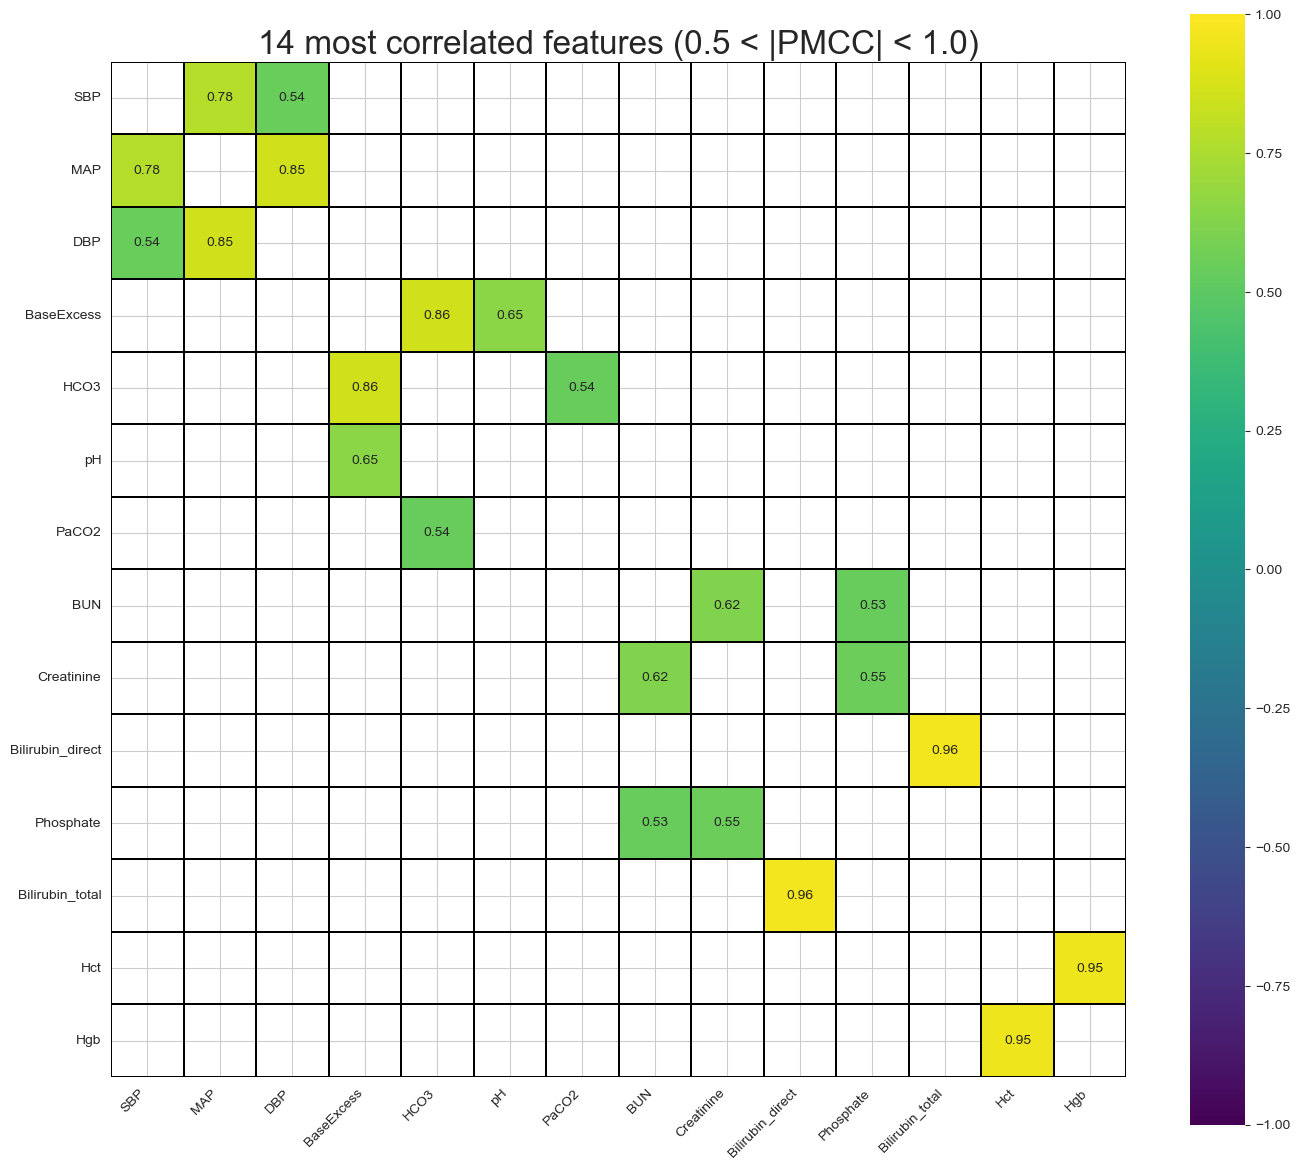

In [125]:
# Get the correlation matrix
corr_matrix = pl.concat(patients).to_pandas().corr()
# Create a mask for correlations with abs value <= 0.5 or exactly 1.0
mask = (abs(corr_matrix) <= 0.5) | (abs(corr_matrix) >= 0.99999)
# Apply the mask (replacing filtered values with NaN)
filtered_corr = corr_matrix.mask(mask)
# Find columns that have at least one value in our desired range
has_correlations = (~filtered_corr.isnull()).sum() > 0
columns_to_keep = filtered_corr.columns[has_correlations]
# Keep only those columns/rows in the correlation matrix
reduced_corr = filtered_corr.loc[columns_to_keep, columns_to_keep]

plt.figure(figsize=(14, 12))
sns.heatmap(
    reduced_corr,
    xticklabels=True,
    yticklabels=True,
    cmap="viridis",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    annot=True,
    #mask=np.triu(reduced_corr), # keep lower triangle only
    linecolor="black",
    linewidths=0.25,
)

plt.title(f'{len(columns_to_keep)} most correlated features (0.5 < |PMCC| < 1.0)', fontsize=24)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{root}/plots/correlation_matrix.png", format="png")
plt.show()

# Train/test split
Ensure enough sepsis patient representation in train and test sets

In [126]:
sepsis_patients: list[pl.DataFrame] = []
non_sepsis_patients: list[pl.DataFrame] = []

for patient in tqdm(patients, "Splitting sepsis/non-sepsis patients"):
	if patient.select(pl.any("SepsisLabel")).item():
		sepsis_patients.append(patient)
	else:
		non_sepsis_patients.append(patient)

Splitting sepsis/non-sepsis patients: 100%|██████████| 40336/40336 [00:02<00:00, 18883.26it/s]


In [127]:
train_sepsis_patients, test_sepsis_patients = train_test_split(sepsis_patients)
train_non_sepsis_patients, test_non_sepsis_patients = train_test_split(non_sepsis_patients)

In [128]:
ratio: float = len(train_non_sepsis_patients) / len(train_sepsis_patients)
print(f"Ratio: {ratio}")

train_patients: list[pl.DataFrame] = train_sepsis_patients + train_non_sepsis_patients
test_patients: list[pl.DataFrame] = test_sepsis_patients + test_non_sepsis_patients

print(f"Number of sepsis patients in training set: {len(train_sepsis_patients)}")
print(f"Number of non-sepsis patients in training set: {len(train_non_sepsis_patients)}")
print(f"Number of patients in training set: {len(train_patients)}\n")
print(f"Number of sepsis patients in testing set: {len(test_sepsis_patients)}")
print(f"Number of non-sepsis patients in testing set: {len(test_non_sepsis_patients)}")
print(f"Number of patients in testing set: {len(test_patients)}")

Ratio: 12.757162346521145
Number of sepsis patients in training set: 2199
Number of non-sepsis patients in training set: 28053
Number of patients in training set: 30252

Number of sepsis patients in testing set: 733
Number of non-sepsis patients in testing set: 9351
Number of patients in testing set: 10084


# Data imputation

In [129]:
train_patients_forward = extractor.fill(train_patients, extractor.FillMethod.FORWARD)
train_patients_backward = extractor.fill(train_patients, extractor.FillMethod.BACKWARD)
train_patients_linear = extractor.fill(train_patients, extractor.FillMethod.LINEAR)

Filling gaps in patient data: 100%|██████████| 30252/30252 [00:32<00:00, 931.32it/s] 


In [130]:
fill_to_list: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : train_patients_forward,
	extractor.FillMethod.BACKWARD: train_patients_backward,
	extractor.FillMethod.LINEAR  : train_patients_linear,
    }

fill_to_concat: dict[extractor.FillMethod, pl.DataFrame] = {
	extractor.FillMethod.FORWARD : pl.concat(train_patients_forward, how="vertical"),
	extractor.FillMethod.BACKWARD: pl.concat(train_patients_backward, how="vertical"),
	extractor.FillMethod.LINEAR  : pl.concat(train_patients_linear, how="vertical"),
    }

fill_to_corr = {
	extractor.FillMethod.FORWARD : fill_to_concat[extractor.FillMethod.FORWARD].to_pandas().corr(),
	extractor.FillMethod.BACKWARD: fill_to_concat[extractor.FillMethod.BACKWARD].to_pandas().corr(),
	extractor.FillMethod.LINEAR  : fill_to_concat[extractor.FillMethod.LINEAR].to_pandas().corr(),
    }

In [131]:
fill_methods_to_use: dict[str, extractor.FillMethod] = extractor.best_fill_method_for_feature(fill_to_corr, FEATURES)
train_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(fill_to_list, fill_methods_to_use)

100%|██████████| 3/3 [00:00<00:00, 446.17it/s]

100%|██████████| 3/3 [00:00<00:00, 10999.05it/s]

100%|██████████| 3/3 [00:00<00:00, 13371.85it/s]

100%|██████████| 3/3 [00:00<00:00, 12985.46it/s]

100%|██████████| 3/3 [00:00<00:00, 8805.40it/s]

100%|██████████| 3/3 [00:00<00:00, 8355.19it/s]

100%|██████████| 3/3 [00:00<00:00, 11683.30it/s]

100%|██████████| 3/3 [00:00<00:00, 8097.11it/s]

100%|██████████| 3/3 [00:00<00:00, 10313.86it/s]

100%|██████████| 3/3 [00:00<00:00, 8805.40it/s]

100%|██████████| 3/3 [00:00<00:00, 9460.84it/s]

100%|██████████| 3/3 [00:00<00:00, 9510.89it/s]

100%|██████████| 3/3 [00:00<00:00, 16008.79it/s]

100%|██████████| 3/3 [00:00<00:00, 6936.56it/s]

100%|██████████| 3/3 [00:00<00:00, 8886.24it/s]

100%|██████████| 3/3 [00:00<00:00, 7445.51it/s]

100%|██████████| 3/3 [00:00<00:00, 10913.19it/s]

100%|██████████| 3/3 [00:00<00:00, 11926.93it/s]

100%|██████████| 3/3 [00:00<00:00, 7963.87it/s]

100%|██████████| 3/3 [00:00<00:00, 11376.95it/s]

100%|███████

In [132]:
test_patients_forward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.FORWARD)
test_patients_backward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.BACKWARD)
test_patients_linear: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.LINEAR)

fill_method_to_test_patients: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : test_patients_forward,
	extractor.FillMethod.BACKWARD: test_patients_backward,
	extractor.FillMethod.LINEAR  : test_patients_linear,
    }

test_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(fill_method_to_test_patients, fill_methods_to_use)

Performing mixed fill: 100%|██████████| 10084/10084 [00:19<00:00, 510.56it/s]


# Down sample non-sepsis patient data

In [142]:
mixed_sepsis = []
mixed_non_sepsis = []

for patient in tqdm(train_patients_mixed, "Splitting sepsis/non-sepsis patients"):
	if patient.select(pl.any("SepsisLabel")).item():
		mixed_sepsis.append(patient)
	else:
		mixed_non_sepsis.append(patient)

mixed_non_sepsis = shuffle(mixed_non_sepsis, n_samples=len(mixed_sepsis))
ratio = len(mixed_non_sepsis)/len(mixed_sepsis)
print(f"Downsampled Ratio: {ratio}")
final_train = mixed_non_sepsis + mixed_sepsis

Splitting sepsis/non-sepsis patients: 100%|██████████| 30252/30252 [00:01<00:00, 18068.21it/s]

Downsampled Ratio: 1.0


In [143]:
train = derive.compute_derived_features_polars(pl.concat(final_train, how="vertical"))
train = extractor.compute_expanding_min_max(train)
train = extractor.compute_sliding_stats(train)
test = derive.compute_derived_features_polars(pl.concat(final_train, how="vertical"))
test = extractor.compute_expanding_min_max(test)
test = extractor.compute_sliding_stats(test)

In [144]:
X_train = train.drop("SepsisLabel")
y_train = train.select("SepsisLabel").to_series()
X_test = test.drop("SepsisLabel")
y_test = test.select("SepsisLabel").to_series()

In [145]:
f = make_scorer(fbeta_score, beta=4)

clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric=f, scale_pos_weight=2)
bst = clf.fit(X_train, y_train)

In [146]:
# Get predicted probabilities that the patient gets sepsis at that time
y_pred_proba = bst.predict_proba(X_test)[:, 1]

# Threshold optimisation

In [147]:
# Define threshold range to evaluate
thresholds = np.linspace(0.1, 0.9, 50)
beta = 4

# Store metrics for each threshold
results = []
for threshold in thresholds:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)

    results.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_binary),
        'recall': recall_score(y_test, y_pred_binary),
        'f1': f1_score(y_test, y_pred_binary),
        'fbeta': fbeta_score(y_test, y_pred_binary, beta=beta),
    })

import pandas as pd
results_df = pd.DataFrame(results)

In [148]:
# Find threshold that maximizes a certain metric
best_idx = results_df['fbeta'].idxmax()
best = results_df.iloc[best_idx]
print(best)

threshold    0.246939
precision    0.666807
recall       0.982979
f1           0.794597
fbeta        0.956306
Name: 9, dtype: float64


In [150]:
y_pred_optimal = (y_pred_proba >= best['threshold']).astype(int)

print(f"Best threshold: {best['threshold']:.4f}")
print(f"F-{beta} score at optimal threshold: {best['fbeta']:.4f}")
print(classification_report(y_test, y_pred_optimal))

Best threshold: 0.2469
F-4 score at optimal threshold: 0.9563
              precision    recall  f1-score   support

       False       1.00      0.95      0.97    188978
        True       0.67      0.98      0.79     20915

    accuracy                           0.95    209893
   macro avg       0.83      0.96      0.88    209893
weighted avg       0.97      0.95      0.95    209893



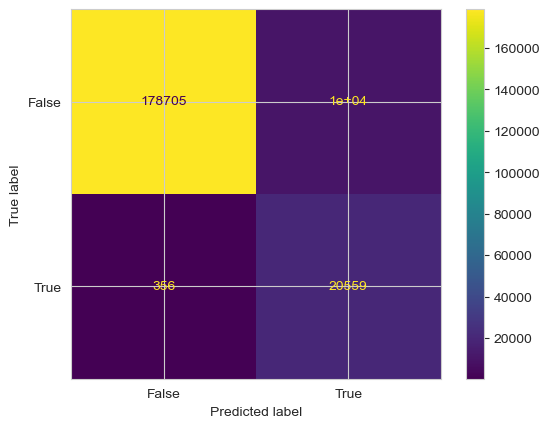

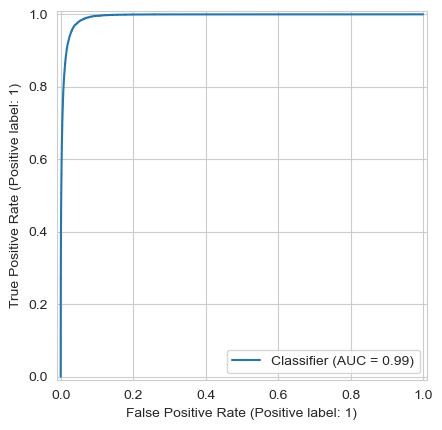

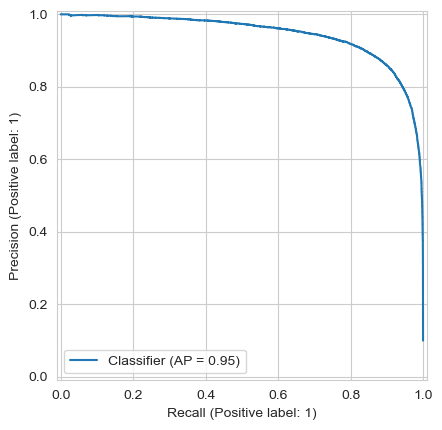

In [151]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)